# CNN Model for Predicting Age from 12-lead ECG signals

In [1]:
import tensorflow as tf # Models ran in venv python 3.9.16 with GPU computing support
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import ast
import ecg_plot
tf.config.list_physical_devices('GPU') # Verify you have a GPU available. Not required

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Loading raw Data into Mutable Dataframes

In [2]:
with tf.device('/CPU:0'):
    ### Loading raw data into mutable Datframes
    ptb = pd.read_csv('../data/ptbxl_database.csv')
    def load_raw_data(df, sampling_rate, path):
        if(sampling_rate == 100):
            data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
        else:
            data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
        data = np.array([signal for signal, meta in data])
        return data
    
    sampling_rate=100
    # load and convert annotation data
    Y = pd.read_csv('../data/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

    # Load raw signal data
    X = load_raw_data(Y, 100, '../data/')

    # Load scp_statements.csv for diagnostic aggregation
    agg_df = pd.read_csv('../data/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    def aggregate_diagnostic(y_dic):
        tmp = []
        for key in y_dic.keys():
            if key in agg_df.index:
                tmp.append(agg_df.loc[key].diagnostic_class)
        return list(set(tmp))


    # Apply diagnostic superclass
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)



## Data Augmentation

### Quality Filter

In [3]:
# X = X[(Y.validated_by_human == True)]
# Y = Y[(Y.validated_by_human == True)]

### Band Pass Filter

In [4]:
import numpy as np
from scipy import signal
with tf.device('/CPU:0'):
    # Define the filter parameters
    fs = 100  # Sampling frequency (Hz)
    lowcut = 0.5  # Lower cutoff frequency (Hz)
    highcut = 40.0  # Higher cutoff frequency (Hz)
    filter_order = 4  # Filter order

    def bandpass(X, fs, lowcut, highcut, filter_order):
        # Apply bandpass filter to each channel
        filtered_data = np.zeros_like(X)
        for i in range(X.shape[2]):
            for j in range(X.shape[0]):
                b, a = signal.butter(filter_order, [lowcut, highcut], fs=fs, btype='band', output='ba')
                filtered_data[j, :, i] = signal.filtfilt(b, a, X[j, :, i])

        # Print the shape of the filtered data
        return filtered_data

### Baseline Drift and Normalization

In [5]:
with tf.device('/CPU:0'):
    def normalize(X, shape = False):
        # Compute mean and standard deviation along axis 1 and 2
        X_mean = np.mean(X)
        X_std = np.std(X)

        if(shape):
            print(X.shape)
        # Normalize data by subtracting mean and dividing by standard deviation
        return ((X - X_mean) / X_std)


    bld = 0.5
    def baseline_drift(X, baseline, range = 0):
        bld_range = (baseline-range, baseline+range)
        random_shifts = np.random.uniform(bld_range[0], bld_range[1], size = X.shape)
        return X + random_shifts

### DA Applyer

In [6]:
with tf.device('/CPU:0'):
    def da_apply(X, functions, shape = False):
        X_final = X.copy()

        # Applys DA Augments in specified order
        for func_dict in functions:
            func = func_dict['func']
            if(func_dict['params'] == None):
                X_final = func(X_final)     
            else:
                params = func_dict['params']
                X_final = func(X_final, *params)  

        if(shape == True):
            print(X_final.shape)

        return X_final

    #func_dict = [{'func': normalize, 'params': [None]}]

    #func_dict = [{'func': baseline_drift, 'params': [0,0.05]}]


    func_dict =[{'func': normalize, 'params': [None]},
                {'func': bandpass, 'params': [100, 0.5, 10, 3]},
                {'func': baseline_drift, 'params': [0,0.075]}]

    X_final = da_apply(X, func_dict) # If you want to experiment with data shape more, use a smaller data size. Subset X

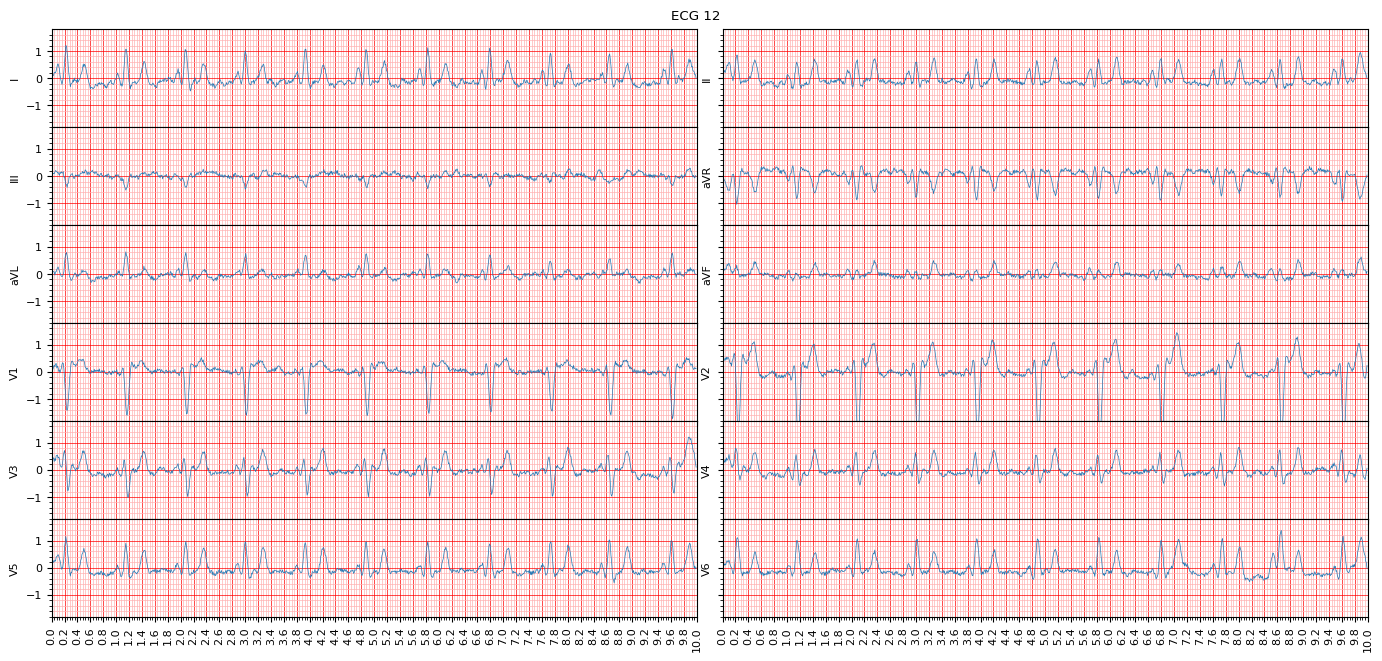

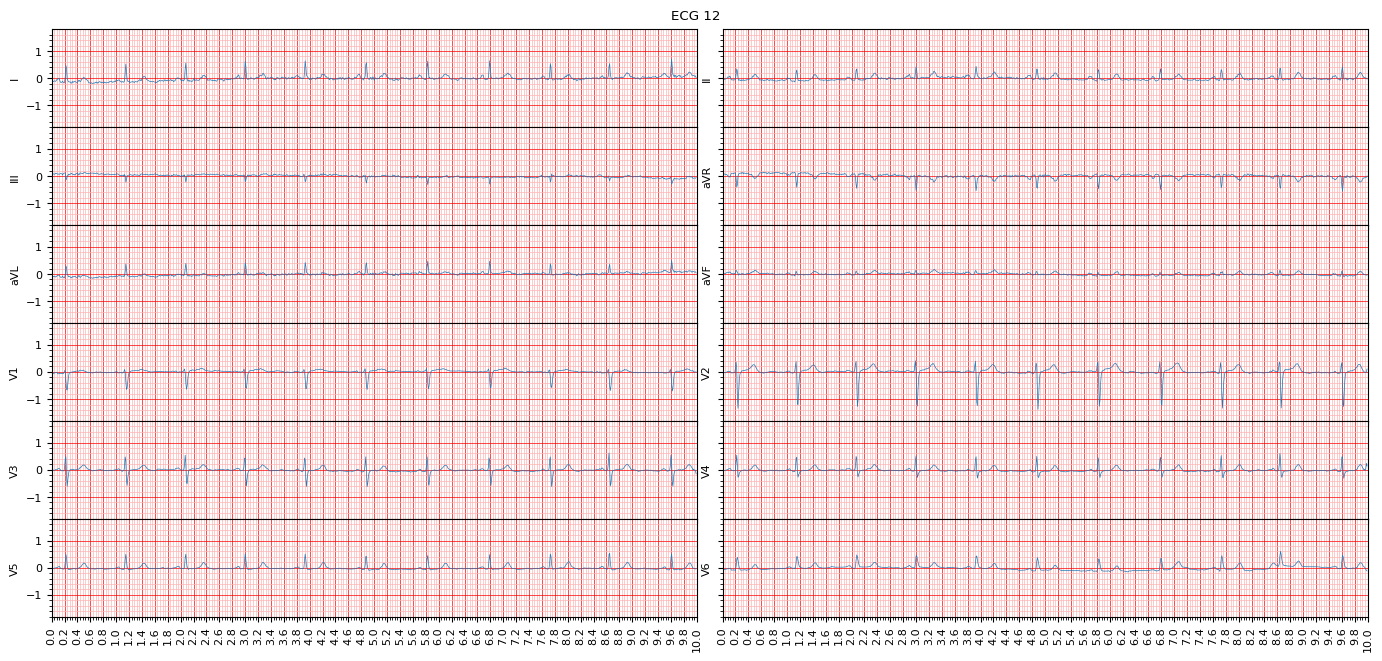

In [7]:
with tf.device('/CPU:0'):
    ecg_plot.plot_12(tf.transpose(X_final, (0,2,1))[0], sample_rate=100)
    ecg_plot.plot_12(tf.transpose(X, (0,2,1))[0], sample_rate=100)

### Splitting data in train, validation, testing data set

In [8]:

with tf.device('/CPU:0'):
    # Split data into train and test
    test_fold =10
    val_fold = 9

    def tvt_split(X, Y, val_fold, test_fold, shape = False):
        X_train = X[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)]
        y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].age

        X_val = X[Y.strat_fold == val_fold]
        y_val = Y[Y.strat_fold == val_fold].age

        X_test = X[(Y.strat_fold == test_fold)]
        y_test = Y[Y.strat_fold == test_fold].age

        y_train = pd.get_dummies(y_train)
        y_val = pd.get_dummies(y_val)
        y_test = pd.get_dummies(y_test)

        y_train = y_train.idxmax(axis = 1).to_numpy()
        y_val = y_val.idxmax(axis = 1).to_numpy()
        y_test = y_test.idxmax(axis = 1).to_numpy()

        rX_train = X_train[(y_train < 89) & (y_train >= 18)]
        ry_train = y_train[(y_train < 89) & (y_train >= 18)]

        rX_val = X_val[(y_val < 89) & (y_val >= 18)]
        ry_val = y_val[(y_val < 89) & (y_val >= 18)]

        rX_test = X_test[(y_test < 89) & (y_test >= 18)]
        ry_test = y_test[(y_test < 89) & (y_test >= 18)]

        if(shape == True):
            print((X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape))

        return rX_train, ry_train, rX_val, ry_val, rX_test, ry_test

    X_train, y_train, X_val, y_val, X_test, y_test = tvt_split(X_final, Y, val_fold, test_fold, True)

((17418, 1000, 12), (17418,), (2183, 1000, 12), (2183,), (2198, 1000, 12), (2198,))


### Data manipulation
* The date of birth only as age at the time of the ECG recording, where ages of more than 89 years appear in the range of 300 years in compliance with HIPAA standards as stated by the PTB-XL data page.

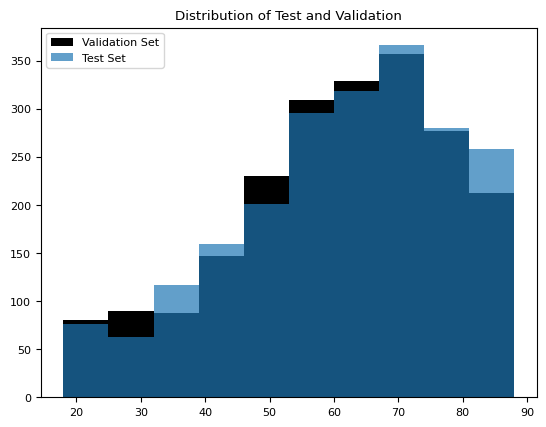

In [9]:
with tf.device('/CPU:0'):
    # Plotting the histograms
    hist_val = plt.hist(y_val, label='Validation Set', color="black")
    hist_test = plt.hist(y_test, label='Test Set', alpha = 0.7)

    plt.legend()
    plt.title("Distribution of Test and Validation")

    plt.show()

## Modelling

### Batching

In [10]:

tf.debugging.disable_traceback_filtering

# Batching
batch_size = 64
num_epochs = 20
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

# Shuffle and batch the dataset
dataset = dataset.shuffle(buffer_size=len(X_train))
dataset = dataset.batch(batch_size)


# Creating the model
ecg_age_model_1 = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters = 16, kernel_size = 7, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 16, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=4, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 64, kernel_size = 3, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Conv1D(filters = 128, kernel_size = 12, strides = 1, padding = "valid", activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool1D(pool_size=2, strides = 1, padding = "valid"),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(128, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),


    tf.keras.layers.Dense(64, activation= 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2, seed = 13),

    tf.keras.layers.Dense(1, activation= 'linear')
])


# Compiling the model
ecg_age_model_1.compile(loss = tf.keras.losses.mse,
                    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0003),
                    metrics = ['mae'])


# Call Backs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta= 0.01,patience = 4, baseline= 0.75)
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: (0.0008) * 10**(epoch/20))
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath='model_checkpoint.h5', save_best_only=True)


# Train the model

ecg_age_model_1.fit(dataset, epochs = num_epochs, validation_data = (X_val, y_val))

Epoch 1/20
266/266 [==============================] - 21s 55ms/step - loss: 3665.4512 - mae: 59.0182 - val_loss: 4413.2202 - val_mae: 65.0320
Epoch 2/20
266/266 [==============================] - 15s 58ms/step - loss: 3423.0315 - mae: 57.2496 - val_loss: 3252.0835 - val_mae: 55.7600
Epoch 3/20
266/266 [==============================] - 14s 51ms/step - loss: 3046.8750 - mae: 53.9655 - val_loss: 2624.4473 - val_mae: 49.8347
Epoch 4/20
266/266 [==============================] - 14s 51ms/step - loss: 2536.1648 - mae: 49.0198 - val_loss: 2204.0071 - val_mae: 45.4226
Epoch 5/20
266/266 [==============================] - 14s 51ms/step - loss: 1961.9841 - mae: 42.8021 - val_loss: 1707.3231 - val_mae: 39.4757
Epoch 6/20
266/266 [==============================] - 14s 51ms/step - loss: 1414.2567 - mae: 35.8604 - val_loss: 1216.2186 - val_mae: 32.8499
Epoch 7/20
266/266 [==============================] - 14s 52ms/step - loss: 940.8900 - mae: 28.6021 - val_loss: 826.9936 - val_mae: 26.5028
Epoch 8/

In [14]:
ecg_age_model_1.evaluate(X_test, y_test)

67/67 [==============================] - 1s 10ms/step - loss: 137.1215 - mae: 9.3362


[137.12152099609375, 9.336234092712402]

## Performance Analysis

532/532 [==============================] - 5s 8ms/step


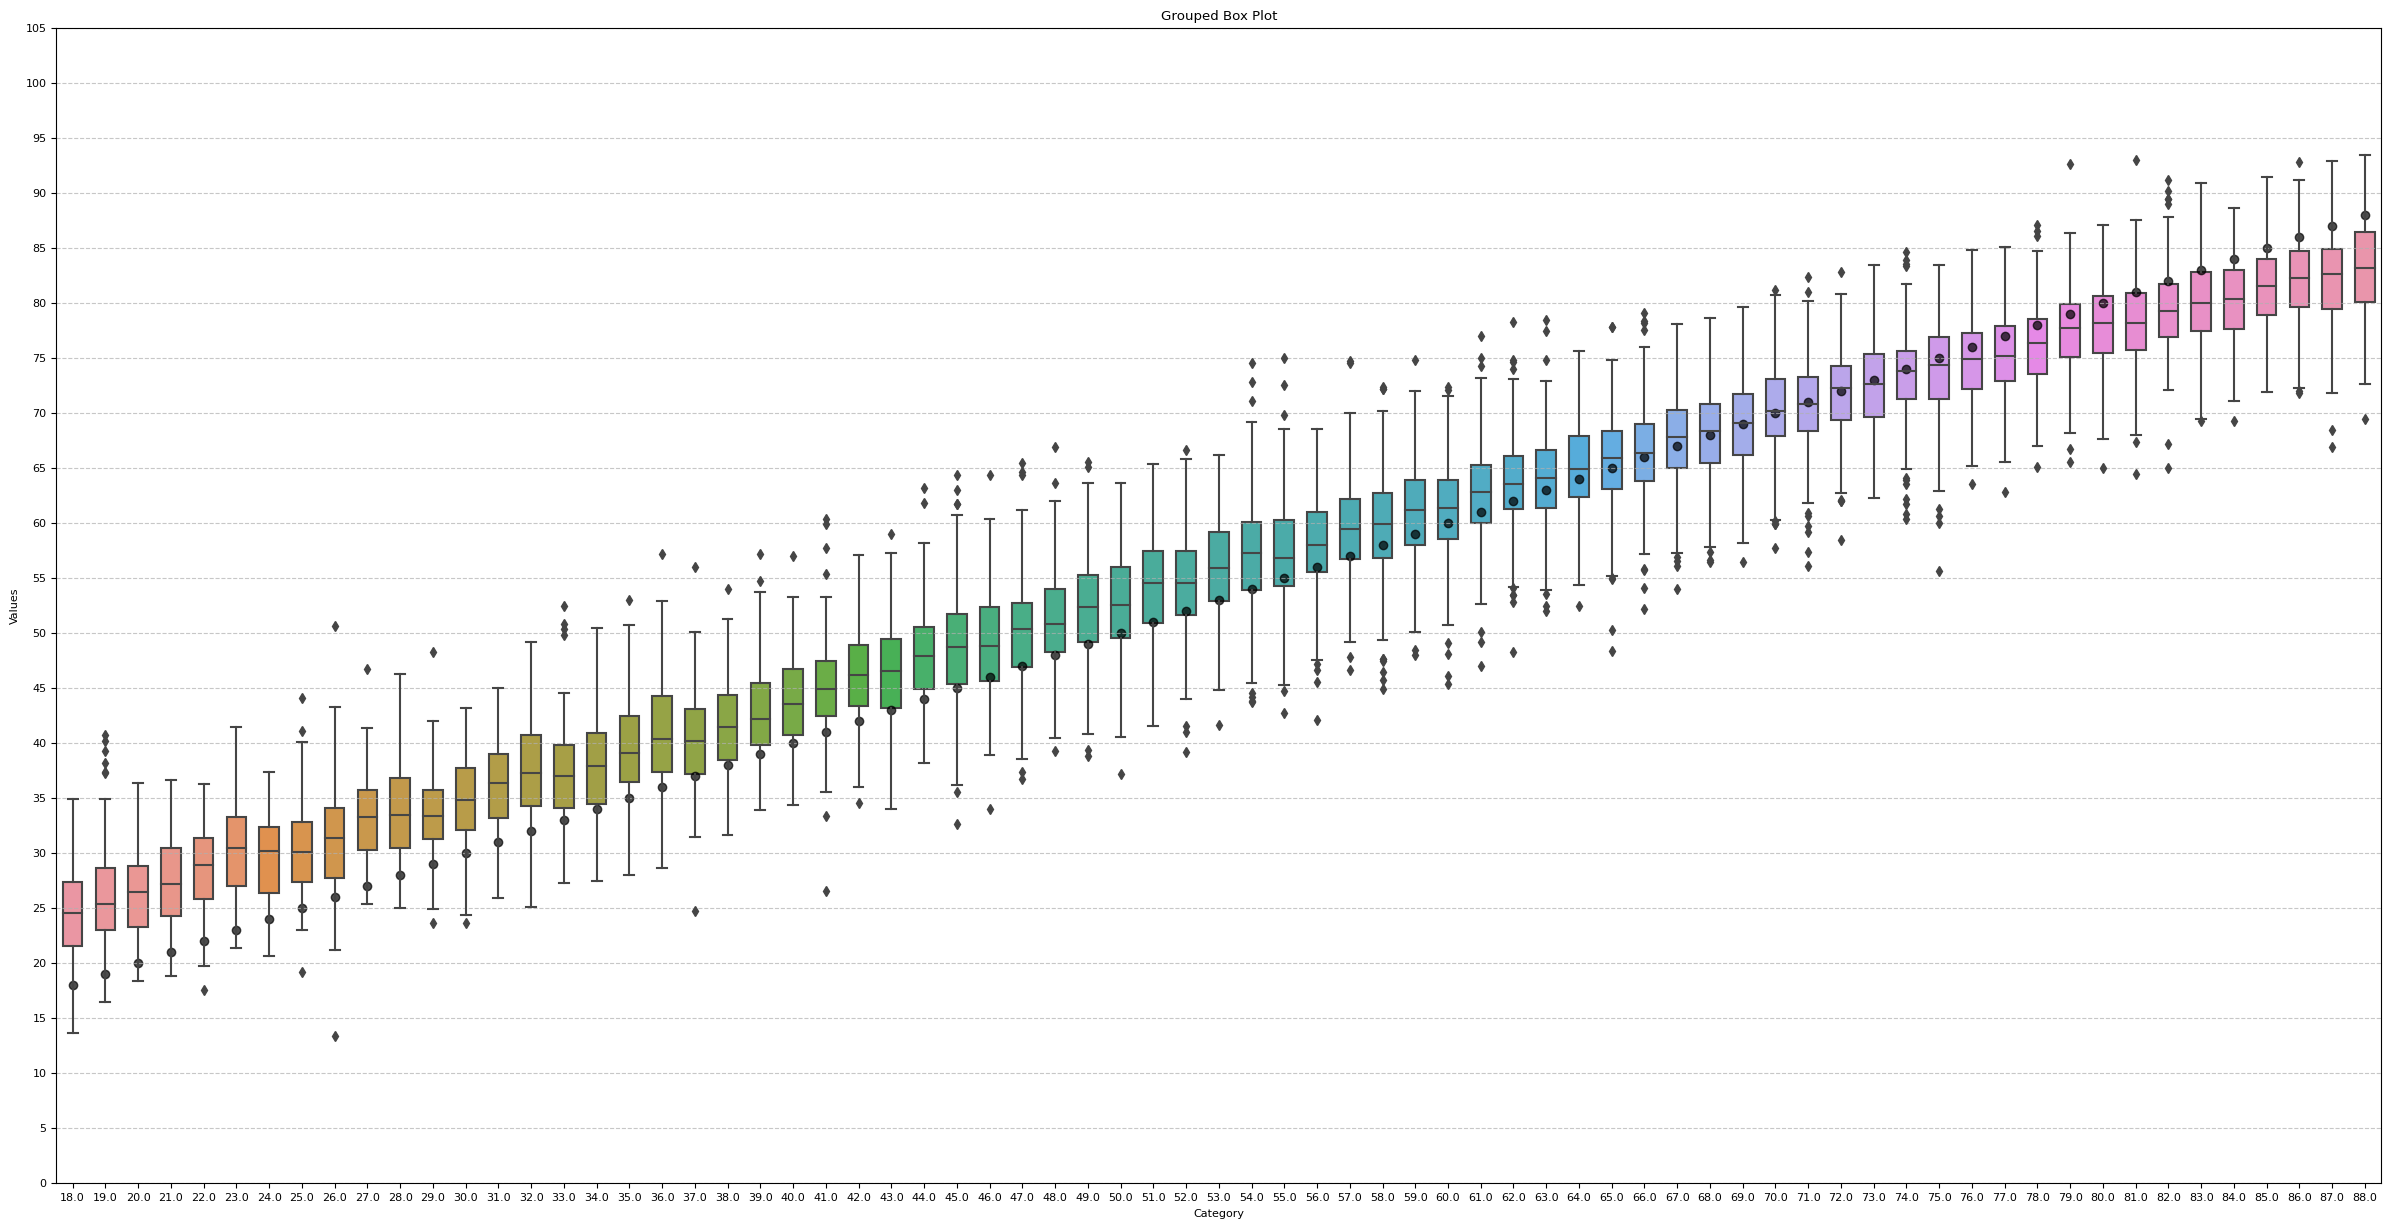

In [12]:
import seaborn as sns

# Predict on train
y_train_pred = ecg_age_model_1.predict(X_train)


# Create a DataFrame from the data
data = pd.DataFrame({'Category': np.squeeze(y_train), 'Values': np.squeeze(y_train_pred)})

# Create a group boxplot using seaborn
plt.figure(figsize=(30, 15))
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.title("Visualization of Train set")
sns.boxplot(x='Category', y='Values', data=data, width=0.6)
category_positions = range(len(data['Category'].unique()))
plt.scatter(category_positions, np.unique(np.squeeze(y_test)), color='black', label='Scatter Plot', alpha = 0.7)
plt.xlabel('Category')
plt.ylabel('Values')
plt.yticks(range(0, 110, 5)) 
plt.title('Grouped Box Plot')
plt.show()

67/67 [==============================] - 1s 12ms/step


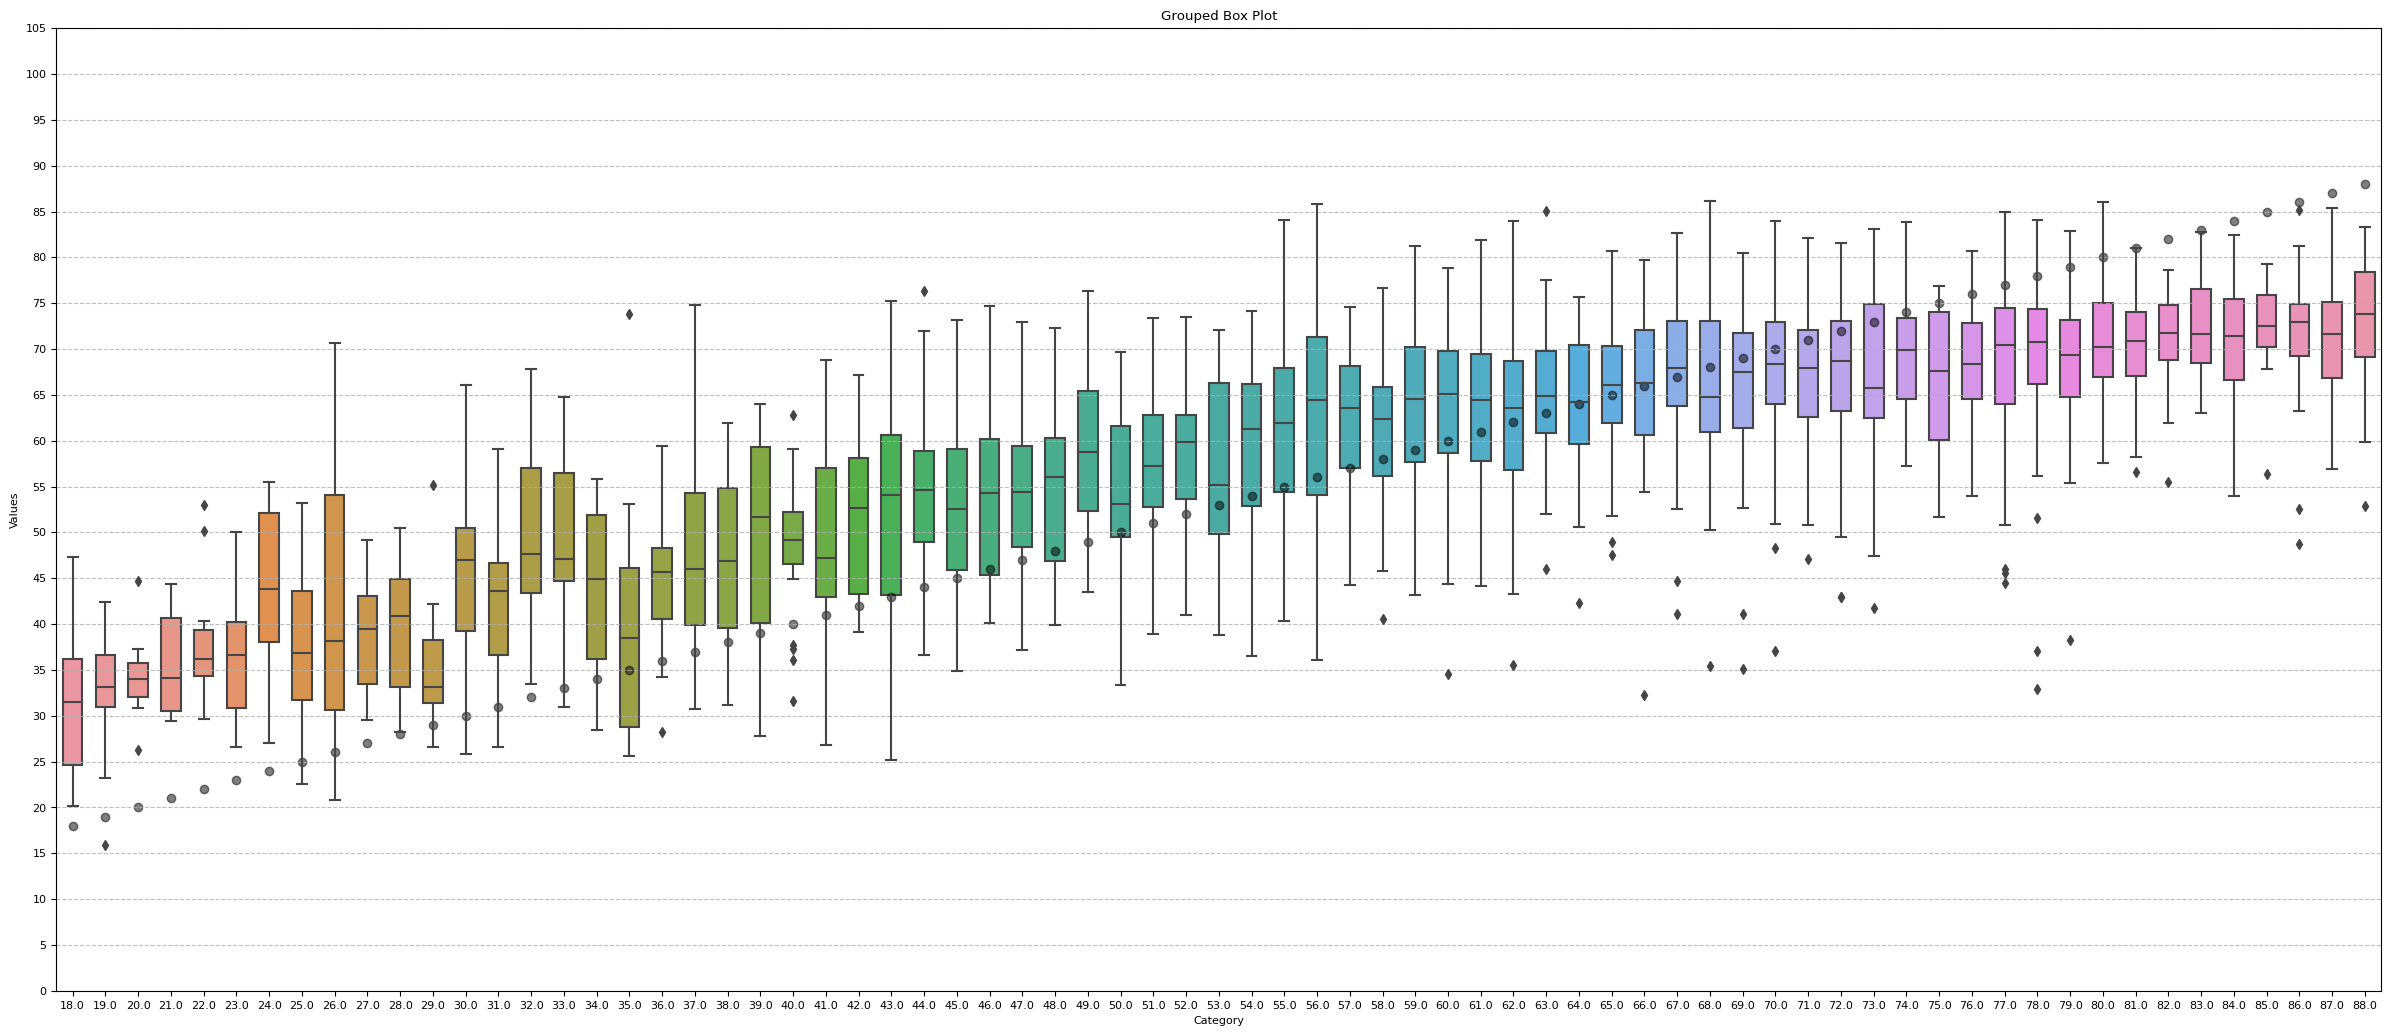

In [13]:
# Predict on train
y_test_pred = ecg_age_model_1.predict(X_test)


# Create a DataFrame from the data
data = pd.DataFrame({'Category': np.squeeze(y_test), 'Values': np.squeeze(y_test_pred)})

# Create a group boxplot using seaborn
plt.figure(figsize=(30,12.5))
plt.grid(True, axis='both', linestyle='--', alpha=0.8)
plt.title("Visualization of Test set")
sns.boxplot(x='Category', y='Values', data=data, width=0.6)

category_positions = range(len(data['Category'].unique()))
plt.scatter(category_positions, np.unique(np.squeeze(y_test)), color='black', label='Scatter Plot', alpha = 0.5)

#plt.scatter(np.unique(np.squeeze(y_test)), np.unique(np.squeeze(y_test)), color='red', label='Scatter Plot')

plt.xlabel('Category')
plt.ylabel('Values')
plt.yticks(range(0, 110, 5)) 
plt.title('Grouped Box Plot')
plt.show()

### Further Data manipulation
We however do not recommend the use of time inversion, spatial inversion, permutation, and lead shuffling, whereas a careful design of all other basic DA techniques is needed. 